In [1]:
import os
import json
from collections import deque
from typing import Dict, List, Optional, Any, Union
import pprint

from langchain_openai import ChatOpenAI
from FPGA_AGI.chains import WebsearchCleaner

from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# Get human objective
# refine it via human in the loop and via adding context (short/long term memory search) -> the output is a json dict of the design
# build the modules and test benches usiiing short and long term memory

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")

llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
bigllm = ChatOpenAI(model='gpt-4-turbo', temperature=0)
gpt4 = ChatOpenAI(model='gpt-4', temperature=0)


webcleaner = WebsearchCleaner.from_llm(llm=bigllm)

def clean_web(concatenated_content):
    try:
        cleaned_concatenated_content = webcleaner.invoke(concatenated_content)
        cleaned_concatenated_content = cleaned_concatenated_content.cleaned
    except:
        cleaned_concatenated_content = concatenated_content.replace('\n\n', '')
    return cleaned_concatenated_content

def context_from_web(url):
    loader = RecursiveUrlLoader(
        url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
    )
    docs = loader.load()

    # Add 
    #docs.extend([*docs_pydantic, *docs_sq])

    # Sort the list based on the URLs in 'metadata' -> 'source'
    d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
    d_reversed = list(reversed(d_sorted))

    # Concatenate the 'page_content' of each sorted dictionary
    concatenated_content = "\n\n\n --- \n\n\n".join(
        [doc.page_content for doc in d_reversed]
    )
    cleaned_concatenated_content = clean_web(concatenated_content)
    return cleaned_concatenated_content


# Context for FFT

In [5]:


# FFT docs 
url = """https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm""" # """https://www.fpga4student.com/2017/04/verilog-code-for-16-bit-risc-processor.html""" # """https://en.wikipedia.org/wiki/Quadruple-precision_floating-point_format"""# 


# Tests

## Simple RISC V CPU

In [57]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

riscv_requirements = requirement_chain.invoke(
    {"objective": """Design a simple educational RISC-V CPU. Make sure that your code is synthesizable and can aesily fit on a zynq7 device. The coding language must be hls c++. The code must be supplied with a lot of comments for educational purposes.""", 
     "context" : concatenated_content}
)

# FFT

In [6]:

fft_requirements = requirement_chain.invoke(
    {"objective": """Build a 128 point fft circuit which is using two 64 point fft modules (named fft64) to compute the 128 point fft. You do not need to design the 64 point fft devices. You can assume that they just exist.
     the input to the fft module is an array of 128 double precision fixed point real numbers (such as a DSP signal measured elsewhere.) The implementation language must be HLS C++. The design must be optimized for maximum performance (speed.)
     The design must be commented with comments indicating where the design is in fact optimized for performance.""", 
     "context" : concatenated_content})

## gaussian mixture

In [15]:
gaussian_requirements = requirement_chain.invoke(
    {"objective": """
     Your task is to build a gaussian mixuture calculator to be implemented on an ultra96-v2 board. The mixture will consist of 10 gaussians. The circuit should take a set of 10 mus, variances, weights and an array of inputs x's. for every value of x the sum of gaussian mixture is computed and an array of output y is generated.
     The calculator must communicate with the rest of the FPGA via axi-dma and must be pynq compatible the language must be xilix HLS cpp. The gaussian's parameters and the input x's must use separate axi dmas and there should be a third axi dma for the output values.
     A very important part of this project is that we want it to be done as fast as possible and it must be parallelized and pipelined as much as possible. The input and output values are in float32 but the computation must be performed in 128 bit fixed point. The output must be converted and returned in float32 format""", 
     "context" : concatenated_content}
)

# Quadruple precision floating point

In [5]:
float128_requirements = requirement_chain.invoke(
    {"objective": """
     Build a quadrouple precision floating point (not the fixed point) exponentiation module. You have to code this 128 bit floating point representation from scratch, using the context I provided, and code the computations based on this representation.""", 
     "context" : concatenated_content}
)

In [6]:
pprint.pprint(requirements.goals)
#requirements.requirements = requirements.requirements[:4]
pprint.pprint(requirements.requirements)

['Design a 128-point FFT circuit using two 64-point FFT modules.',
 'Optimize the design for maximum performance in terms of speed.',
 'Ensure the design is implemented in HLS C++ with appropriate performance '
 'optimization comments.']
['The circuit, named fft128, must be capable of computing a 128-point FFT '
 'using two existing 64-point FFT modules (fft64).',
 'Input to the fft128 module should be an array of 128 double precision fixed '
 'point real numbers.',
 'The implementation must leverage the Cooley–Tukey FFT algorithm, '
 'specifically the radix-2 decimation-in-time (DIT) approach for splitting the '
 '128-point FFT into two 64-point FFTs.',
 'Optimize the design for speed by focusing on efficient data reordering, '
 'minimizing memory accesses, and maximizing parallel execution where '
 'possible.',
 'Include comments in the HLS C++ code to highlight areas where specific '
 'optimizations for performance are implemented.',
 'Ensure the design supports in-place computation

In [9]:
#requirements.requirements.append("The 64-point FFT modules (fft64) do not need to be designed. You must assume that they just exist.")

"Provide a testbench in Verilog to simulate the CPU's operation, including loading test programs and verifying the execution results."

# Knowledge base (vector database)

In [7]:
# retriever

from langchain_community.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import chromadb

embeddings_3_small = OpenAIEmbeddings(model='text-embedding-3-small')
if os.path.isdir('knowledge_base'):
    persistent_client = chromadb.PersistentClient(path="./knowledge_base")
    pdfsearch = Chroma(client=persistent_client, embedding_function=embeddings_3_small)
else:
    pages = []
    for item in ["https://arxiv.org/pdf/1502.07055", "https://arxiv.org/pdf/1810.06885", "https://arxiv.org/pdf/1808.02521"]: # ["https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf"]: # 
        loader = PyPDFLoader(item, extract_images=True) #"https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf"
        pages += loader.load()
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = text_splitter.split_documents(pages)
    pdfsearch = Chroma.from_documents(texts, embeddings_3_small, collection_name= "knowledge_base", persist_directory="./knowledge_base")

In [12]:
#retriever=pdfsearch.as_retriever(search_kwargs={"k": 2})
#retriever.get_relevant_documents('FFT algorithm')

[Document(page_content='numbers of complex multiplications, whereas radix -2 \nFFT algorithm is the simpl est form in all FFT algorithms.  \nFurthermore, it has a regularity mode that makes it \nsuitable for VLSI implementation as shown in the \nfallowing Eq. 2: \n  \nNN1122\nnm m nm\nN N N\nn 0 n 0 22X[m] x[2n]W W x[2n 1]W\uf02d\uf02d\n\uf03d\uf03d\uf03d \uf02b \uf02b\uf0e5\uf0e5\n (2) \n \n FFT algorithm  relies on a ‘divide -and-conquer’  \nmethodology, which divides the N coefficient points \ninto smaller blocks in different stages. The first stage \ncomputes with groups of two coefficients, yielding N/2 \nblocks, each computing the addition and subtraction of \nthe coefficients scaled by the corres ponding twiddle \nfactors, called a butterfly for its cross -over appearance \nas shown in Fig. 1.  \n \nThese results are used to compute the next state  of N /4 \nblocks, which will then  combine  the results of two \nprevious blocks, combining four coefficients at this \npoint. This 

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two 64-point FFT modules.', 'Optimize the design for maximum performance (speed).', 'Ensure the design is implemented in HLS C++ with appropriate performance optimization comments.']\n                    requirements:\n                    ['The circuit, named fft128, must compute a 128-point FFT using two existing 64-point FFT modules (fft64).', 'Input to the fft128 module: An array of 128 double precision fixed point real numbers.', 'The design must be implemented in HLS C++.', 'Performance optimizations must be clearly commented within the code, indicating the specific optimization strategies employed.', 'Utilize the Cooley–Tukey FFT algorithm for the design, specifically leveraging the radix-2 decimation-in-time (DIT) ap

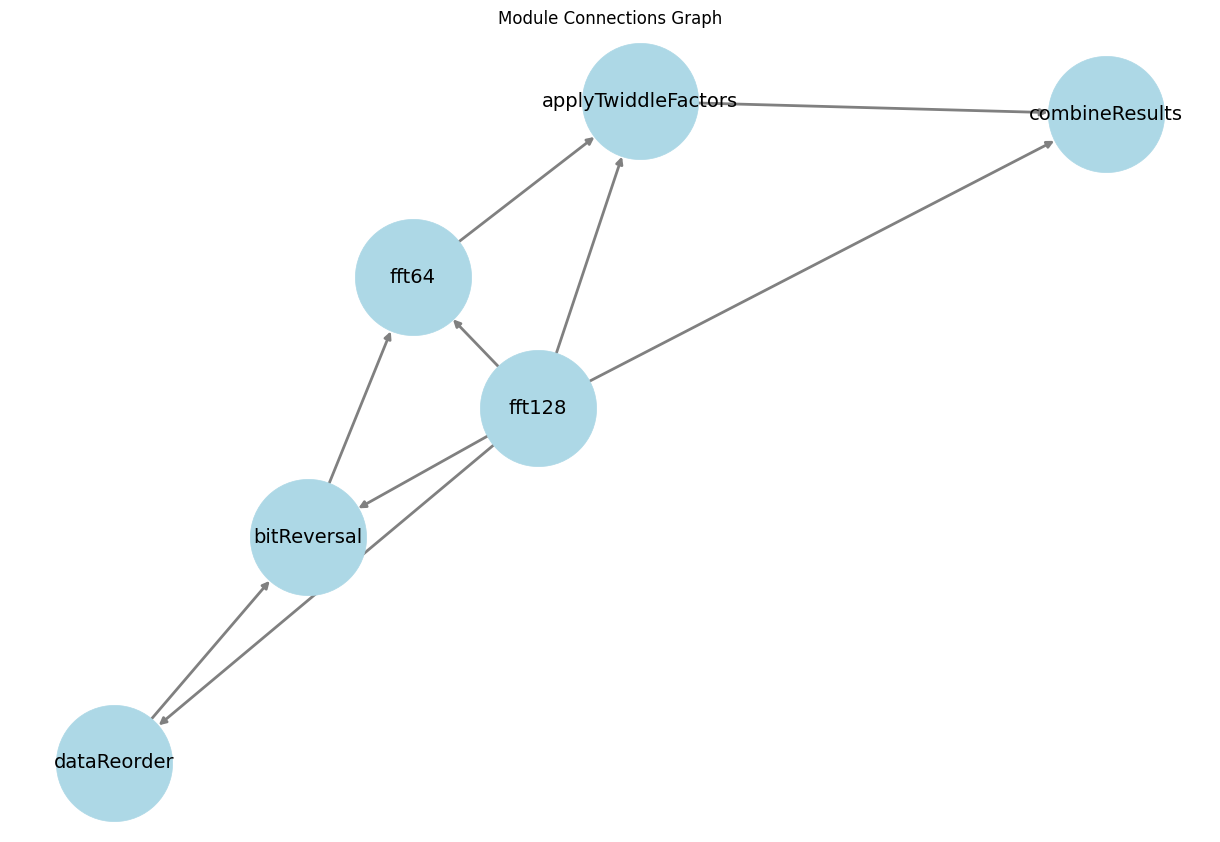

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two 64-point FFT modules.', 'Optimize the design for maximum performance (speed).', 'Ensure the design is implemented in HLS C++ with appropriate performance optimization comments.']\n                    requirements:\n                    ['The circuit, named fft128, must compute a 128-point FFT using two existing 64-point FFT modules (fft64).', 'Input to the fft128 module: An array of 128 double precision fixed point real numbers.', 'The design must be implemented in HLS C++.', 'Performance optimizations must be clearly commented within the code, indicating the specific optimization strategies employed.', 'Utilize the Cooley–Tukey FFT algorithm for the design, specifically leveraging the radix-2 decimation-in-time (DIT) ap

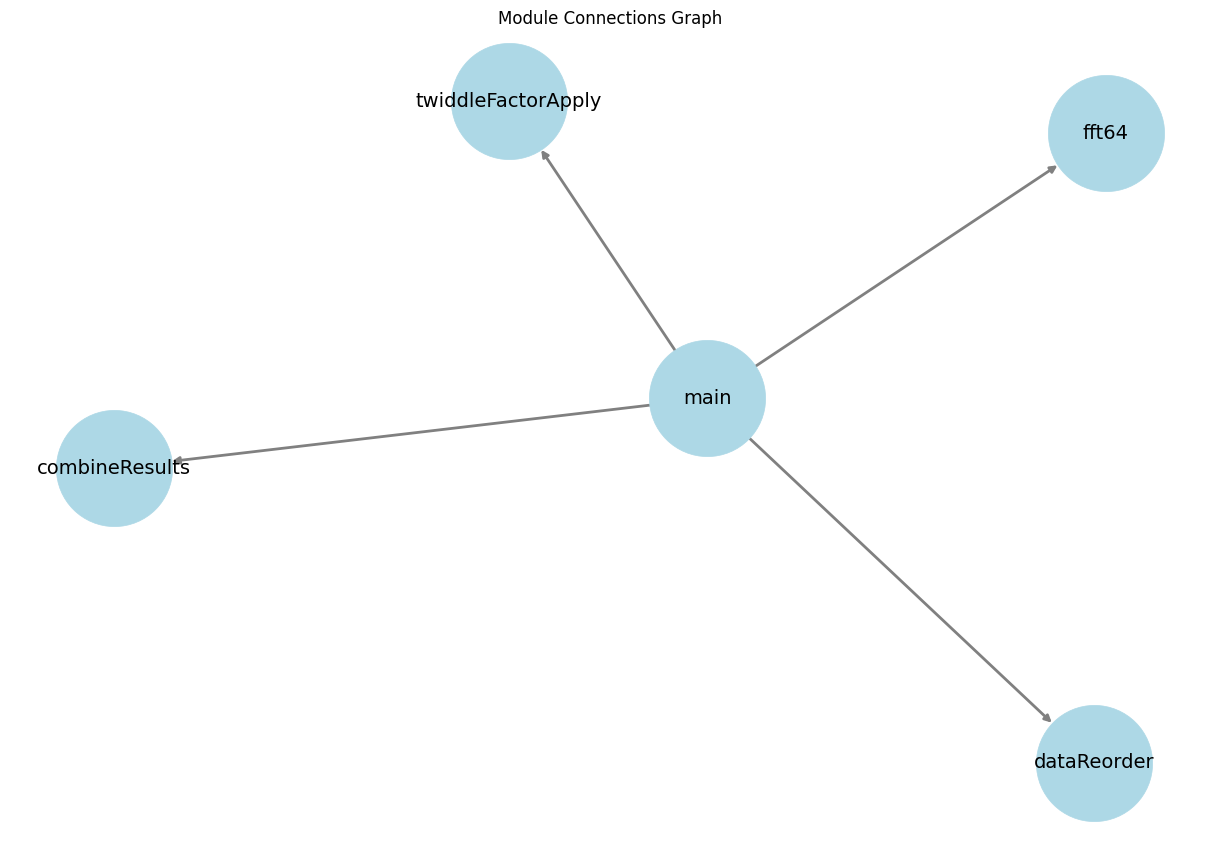

In [22]:
import importlib
from FPGA_AGI import tools
importlib.reload(tools)
from FPGA_AGI import parameters
importlib.reload(parameters)
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI import prompts
importlib.reload(prompts)
from FPGA_AGI import chains
importlib.reload(chains)
from langchain_core.prompts import HumanMessagePromptTemplate
from FPGA_AGI import agents
importlib.reload(agents)
from FPGA_AGI.agents import Engineer
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI.utils import plot_graph


#review = None
for model, model_str in zip([llm, bigllm], ['gpt-3.5', 'gpt-4-turbo']):
    for i in range(2):
        sol_dir = f'FFT_design_{model_str}_evaluation_gpt-4_{i}'
        R = Engineer(model=model, evaluator_model=gpt4, retriever=pdfsearch.as_retriever(search_kwargs={"k": 1}), solution_num=sol_dir)
        try:
            if review:
                R.lit_review_results = review
            R.invoke(goals=requirements.goals, requirements=requirements.requirements, input_context= '')
            with open(f"solution_{sol_dir}/requirements.txt", "w") as file:
                file.write("Goals: \n" + '\n'.join(requirements.goals) + "\nRequirements: \n" + '\n'.join(requirements.requirements))
            plot_graph(R.hierarchical_solution_result, save_path=f"solution_{sol_dir}/graph.png")
        except:
            pass
        review = R.lit_review_results

In [65]:
review = R.lit_review_results

In [ ]:
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, FunctionMessage
input_message = HumanMessage(f"""Design the architecture graph for the following goals, requirements and input context provided by the user. \
The language of choice for coding the design is {R.language}.
To help you further, you are also provided with literature review performed by another agent.
Goals:
{str(R.goals)}

Requirements:
{str(R.requirements)}
user input context:
{R.input_context}

Literature review, methodology:
{R.lit_review_results.methodology}
Literature review, implementation:
{R.lit_review_results.implementation}
""", name="researcher"
                         )

In [56]:
R.hierarchical_design_agent.invoke({"messages": [input_message]})

Thought
{'graph': [{'name': 'Instruction Memory', 'description': 'Stores the set of instructions that the CPU will execute. This module should be implemented using BRAM to optimize resource usage on the Zynq-7 FPGA.', 'connections': ['Control Unit'], 'ports': ['clk (input)', 'reset (input)', 'addr (input)', 'instr (output)'], 'module_template': '// Instruction Memory Module\nmodule InstructionMemory(clk, reset, addr, instr);\ninput clk, reset;\ninput [31:0] addr;\noutput [31:0] instr;\n// PLACEHOLDER: Define BRAM or similar technology to store instructions\nendmodule'}, 'name', 'General Purpose Registers', 'description', 'Holds the values of registers that can be accessed and modified by the CPU during instruction execution. Optimized for quick access and minimal resource usage.', 'connections', 'ALU', 'ports', 'clk (input)', 'reset (input)', 'read_reg1 (input)', 'read_reg2 (input)', 'write_reg (input)', 'write_data (input)', 'read_data1 (output)', 'read_data2 (output)', 'module_templa

ValidationError: 86 validation errors for SystemDesign
graph -> 1
  value is not a valid dict (type=type_error.dict)
graph -> 2
  value is not a valid dict (type=type_error.dict)
graph -> 3
  value is not a valid dict (type=type_error.dict)
graph -> 4
  value is not a valid dict (type=type_error.dict)
graph -> 5
  value is not a valid dict (type=type_error.dict)
graph -> 6
  value is not a valid dict (type=type_error.dict)
graph -> 7
  value is not a valid dict (type=type_error.dict)
graph -> 8
  value is not a valid dict (type=type_error.dict)
graph -> 9
  value is not a valid dict (type=type_error.dict)
graph -> 10
  value is not a valid dict (type=type_error.dict)
graph -> 11
  value is not a valid dict (type=type_error.dict)
graph -> 12
  value is not a valid dict (type=type_error.dict)
graph -> 13
  value is not a valid dict (type=type_error.dict)
graph -> 14
  value is not a valid dict (type=type_error.dict)
graph -> 15
  value is not a valid dict (type=type_error.dict)
graph -> 16
  value is not a valid dict (type=type_error.dict)
graph -> 17
  value is not a valid dict (type=type_error.dict)
graph -> 18
  value is not a valid dict (type=type_error.dict)
graph -> 19
  value is not a valid dict (type=type_error.dict)
graph -> 20
  value is not a valid dict (type=type_error.dict)
graph -> 21
  value is not a valid dict (type=type_error.dict)
graph -> 22
  value is not a valid dict (type=type_error.dict)
graph -> 23
  value is not a valid dict (type=type_error.dict)
graph -> 24
  value is not a valid dict (type=type_error.dict)
graph -> 25
  value is not a valid dict (type=type_error.dict)
graph -> 26
  value is not a valid dict (type=type_error.dict)
graph -> 27
  value is not a valid dict (type=type_error.dict)
graph -> 28
  value is not a valid dict (type=type_error.dict)
graph -> 29
  value is not a valid dict (type=type_error.dict)
graph -> 30
  value is not a valid dict (type=type_error.dict)
graph -> 31
  value is not a valid dict (type=type_error.dict)
graph -> 32
  value is not a valid dict (type=type_error.dict)
graph -> 33
  value is not a valid dict (type=type_error.dict)
graph -> 34
  value is not a valid dict (type=type_error.dict)
graph -> 35
  value is not a valid dict (type=type_error.dict)
graph -> 36
  value is not a valid dict (type=type_error.dict)
graph -> 37
  value is not a valid dict (type=type_error.dict)
graph -> 38
  value is not a valid dict (type=type_error.dict)
graph -> 39
  value is not a valid dict (type=type_error.dict)
graph -> 40
  value is not a valid dict (type=type_error.dict)
graph -> 41
  value is not a valid dict (type=type_error.dict)
graph -> 42
  value is not a valid dict (type=type_error.dict)
graph -> 43
  value is not a valid dict (type=type_error.dict)
graph -> 44
  value is not a valid dict (type=type_error.dict)
graph -> 45
  value is not a valid dict (type=type_error.dict)
graph -> 46
  value is not a valid dict (type=type_error.dict)
graph -> 47
  value is not a valid dict (type=type_error.dict)
graph -> 48
  value is not a valid dict (type=type_error.dict)
graph -> 49
  value is not a valid dict (type=type_error.dict)
graph -> 50
  value is not a valid dict (type=type_error.dict)
graph -> 51
  value is not a valid dict (type=type_error.dict)
graph -> 52
  value is not a valid dict (type=type_error.dict)
graph -> 53
  value is not a valid dict (type=type_error.dict)
graph -> 54
  value is not a valid dict (type=type_error.dict)
graph -> 55
  value is not a valid dict (type=type_error.dict)
graph -> 56
  value is not a valid dict (type=type_error.dict)
graph -> 57
  value is not a valid dict (type=type_error.dict)
graph -> 58
  value is not a valid dict (type=type_error.dict)
graph -> 59
  value is not a valid dict (type=type_error.dict)
graph -> 60
  value is not a valid dict (type=type_error.dict)
graph -> 61
  value is not a valid dict (type=type_error.dict)
graph -> 62
  value is not a valid dict (type=type_error.dict)
graph -> 63
  value is not a valid dict (type=type_error.dict)
graph -> 64
  value is not a valid dict (type=type_error.dict)
graph -> 65
  value is not a valid dict (type=type_error.dict)
graph -> 66
  value is not a valid dict (type=type_error.dict)
graph -> 67
  value is not a valid dict (type=type_error.dict)
graph -> 68
  value is not a valid dict (type=type_error.dict)
graph -> 69
  value is not a valid dict (type=type_error.dict)
graph -> 70
  value is not a valid dict (type=type_error.dict)
graph -> 71
  value is not a valid dict (type=type_error.dict)
graph -> 72
  value is not a valid dict (type=type_error.dict)
graph -> 73
  value is not a valid dict (type=type_error.dict)
graph -> 74
  value is not a valid dict (type=type_error.dict)
graph -> 75
  value is not a valid dict (type=type_error.dict)
graph -> 76
  value is not a valid dict (type=type_error.dict)
graph -> 77
  value is not a valid dict (type=type_error.dict)
graph -> 78
  value is not a valid dict (type=type_error.dict)
graph -> 79
  value is not a valid dict (type=type_error.dict)
graph -> 80
  value is not a valid dict (type=type_error.dict)
graph -> 81
  value is not a valid dict (type=type_error.dict)
graph -> 82
  value is not a valid dict (type=type_error.dict)
graph -> 83
  value is not a valid dict (type=type_error.dict)
graph -> 84
  value is not a valid dict (type=type_error.dict)
graph -> 85
  value is not a valid dict (type=type_error.dict)
graph -> 86
  value is not a valid dict (type=type_error.dict)

In [46]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field


class Module(BaseModel):
    """module definition"""
    name: str = Field(description="Name of the module.")
    description: str = Field(description="Module description including detailed explanation of what the module does and how to achieve it. Think of it as a code equivalent of the module without coding it.")
    connections: List[str] = Field(description="List of the modules connecting to this module (be it via input or output).")
    ports: List[str] = Field(description="List of input output ports inlcuding clocks, reset etc.")
    module_template: str = Field(description="Outline of the HDL/HLS code with placeholders and enough comments to be completed by a coder. The outline must include module names and ports. The placeholders must be comments starting with PLACEHOLDER:")

class SystemDesign(BaseModel):
    """system design"""
    graph: List[Module] = Field(
        description="""List of modules"""
        )
    
test = PydanticOutputParser(pydantic_object=SystemDesign)

In [18]:
from pprint import pprint
pprint(input_message.content)

('Design the architecture graph for the following goals, requirements and '
 'input context provided by the user. The language of choice for coding the '
 'design is verilog.\n'
 'To help you further, you are also provided with literature review performed '
 'by another agent.\n'
 'Goals:\n'
 "['Design a simple educational RISC-V CPU that is synthesizable and fits on a "
 "Zynq-7 FPGA device.', 'Ensure the design is implemented in Verilog with "
 "extensive comments for educational purposes.']\n"
 '\n'
 'Requirements:\n'
 "['The CPU must be based on the RISC-V architecture, specifically tailored "
 "for educational purposes.', 'The design should include a set of basic "
 'instructions such as Load Word, Store Word, Add, Subtract, Invert, Logical '
 'Shift Left, Logical Shift Right, Bitwise AND, Bitwise OR, Set on Less Than, '
 "Branch on Equal, Branch on Not Equal, and Jump.', 'Implement a Harvard "
 "architecture data path to separate instruction and data memories.', 'Design "
 'and i